In [1]:
import torch
import torch.nn as nn
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# from generate_data import ARData, fixed_ar_coefficients
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import os
from torchvision.transforms import transforms
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
#ZXY = Altered point
num_epochs = 40
learning_rate = 0.1
batch_size = 128
dtype = torch.long
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [3]:
device

device(type='cuda', index=0)

#Dataset structure#
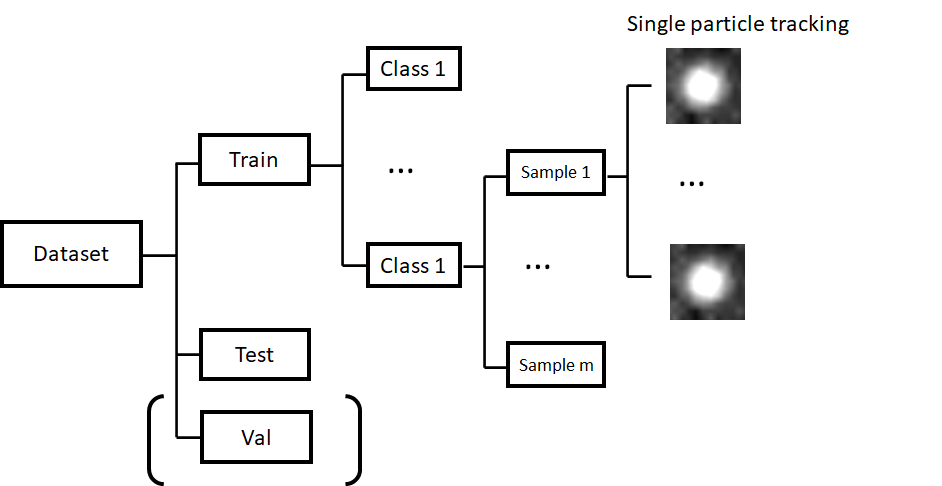

In [4]:
#required size Resnet 224, 224
#              Inception v3 N x 3 x 299 x 299
resize  = torchvision.transforms.Resize((224, 224))
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])## need mean and std
preprocessor = torchvision.transforms.Compose([ 

                                               resize,
                                               torchvision.transforms.ToTensor(), 
                                               normalize,
                                               ])
preprocessor2 = torchvision.transforms.Compose([ 
                                               #torchvision.transforms.RandomRotation(20),
                                               #torchvision.transforms.RandomHorizontalFlip(),
                                               torchvision.transforms.ToTensor(), #ToTensor transforms the image to a tensor with range [0,1]
                                               
                                               ])

In [5]:
# custom dataset
class MyDataset_3D(Dataset):
    def __init__(self, data_path, transforms=None):
        self.path = data_path
        #self.y = labels
        self.transforms = transforms
        self.classes, self.class_to_idx = self.find_classes()
        self.folders = self.folder_loader()
        print(self.class_to_idx)
    
    def find_classes(self):
        classes = os.listdir(self.path)
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

    #load all video folders into the list
    def folder_loader(self):
        folders = []
        for num in self.classes:
            class_dir = os.path.join(self.path, num)
            one_class_folders = os.listdir(class_dir)
            one_class_folders = [os.path.join(class_dir, i) for i in one_class_folders]
            folders += one_class_folders
            
        return folders
             
        
    def __len__(self):
        
        return (len(self.folders))
    
    def frame_average(self, X, average = 5):
        timesteps, C, H, W = X.size()
        
        X_averaged = []
        for i in range(0, timesteps-average-1, average):
            X_averaged.append(X[i:i+average].mean(0))
        X_averaged.append(X[-average:].mean(0))
        
        return torch.stack(X_averaged, dim = 0)
            
            
        
    def read_images(self, one_folder):
        X = []
        frames = os.listdir(one_folder)
        count = 1
        for frame in frames:
            #pay attenention to convert type
            #Image.open().convert('L') 
            #print(os.path.join(one_folder, frame))
            image = Image.open(os.path.join(one_folder, frame))
#             'I' is 32-bit signed integer pixels, you can use 'I;16',
#              but in torchvision.transforms.ToTensor(), if pic.mode == 'I;16':
#              img = torch.from_numpy(np.array(pic, np.int16, copy=False))
#              np.int16 is singed 16 bit

            #ZXY
            #image = image.resize(size = (20,20))
            if self.transforms:
                image = self.transforms(image)
            else:
                image = torch.tensor(image)    

            image = image.float()

            X.append(image)
            #print(image.shape)
            count = count+1
            
          
        X = torch.stack(X, dim = 0)
        
        #normalize X over the single particle whole track
        Xmax = torch.max(X)
        Xmin = torch.min(X)
        X = (X-Xmin)/(Xmax-Xmin)
        X = (X-torch.mean(X))/torch.std(X)
        
        #X = self.frame_average(X)
        #print(X.shape)
        
        #ZXY elongate time series
#         X = torch.cat((X,torch.flip(X, [0]),X), dim = 0)
#         X = torch.cat((X,torch.flip(X, [0]),X), dim = 0)
        
#         ZXY change input dim
#         X = X.view(-1,4,10,10)
#         print(torch.mean(X[48]))

        return X
        
        
    def __getitem__(self, index):
        X = []
        
        folder = self.folders[index]
        #print(folder)
        class_name = os.path.basename(os.path.dirname(folder)) 
        #print(class_name)
        X = self.read_images(folder)

        #print(self.class_to_idx)
        y = torch.LongTensor([self.class_to_idx[class_name]])
        #print(y)

        return X, y
    
#     image = Image.open('C:\\Users\\ZXY\\Desktop\\ASU\\Lab\\CellClassfier\\dataset1\\0_5um\\ID1\\000001.tif')
#     pixels = list(image.getdata())

In [6]:
Dataset_path = r'C:\Users\ZXY\Desktop\ASU\Lab\CellClassfier\dataset_EvU\train'
train_data = MyDataset_3D(Dataset_path, preprocessor2)

train_loader = DataLoader(train_data, batch_size, shuffle=True)

{'Ecoli': 0, 'Urine': 1}


In [7]:
Dataset_path = r'C:\Users\ZXY\Desktop\ASU\Lab\CellClassfier\dataset_EvU\test'
test_data = MyDataset_3D(Dataset_path, preprocessor2)

test_loader = DataLoader(test_data, batch_size, shuffle=True)

{'Ecoli': 0, 'Urine': 1}


In [8]:
Dataset_path = r'C:\Users\ZXY\Desktop\ASU\Lab\CellClassfier\dataset_EvU\val'
val_data = MyDataset_3D(Dataset_path, preprocessor2)

val_loader = DataLoader(val_data, batch_size, shuffle=True)

{'Ecoli': 0, 'Urine': 1}


In [9]:
for i, (X_batch, labels_batch )in enumerate(train_loader):
    print(X_batch.shape)
    print(labels_batch)
    break

torch.Size([128, 500, 1, 10, 10])
tensor([[1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
    

In [10]:
# for i, (X_batch, labels_batch )in enumerate(test_loader):
#     print(X_batch.shape)
#     print(labels_batch)
#     break

In [11]:
# predict
def predict(model, loader):
    model.to(device)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        all_predicted = []
        labels_total = []       
        
        for images, labels in loader:
            images = images.to(device,dtype=torch.float)
            labels = labels.squeeze().to(device)

            outputs, _ = model.forward(images)
                
            _, predicted = torch.max(outputs.data, 1)# _ are max values, predicts are their indexs
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predicted += predicted.cpu().numpy().tolist()
            labels_total += labels.cpu().numpy().tolist()
#             print(outputs)
#             print('predicted',predicted)
#             print('labels', labels)
#             print(correct)
#             print(total)
#             print(predicted == labels)

        print("Accuracy: {}%" .format(100* correct/total),'correct', correct, 'total',total)
    model.train()
    return all_predicted, labels_total, format(100* correct/total)

In [12]:
#####################
# Build model
#####################

# Here we define our model as a class
class CNN_LSTM(nn.Module):
    def __init__(self, input_ch = 1, N_classes = 2):
        super(CNN_LSTM, self).__init__()
        self.input_ch = input_ch
        self.ch1, self.ch2 = 16, 32 
        self.cnn_embed_dim = 8 #cnn-embedded dim 
        self.k1, self.k2 = 5, 5
        self.h_d = 8
        self.num_layers = 2
        self.N_classes = N_classes

        self.cnn1 = nn.Conv2d(self.input_ch, self.ch1, self.k1)
        self.cnn2 = nn.Conv2d(self.ch1, self.ch2, self.k2)

        self.fc1 = nn.Linear(((10-self.k1+1)-self.k2+1)**2 * self.ch2, self.cnn_embed_dim) # 10 is image size
        
        self.lstm = nn.LSTM(self.cnn_embed_dim, self.h_d, self.num_layers)
        
        self.fc2 = nn.Linear(self.h_d, self.N_classes)
        self.softmax = nn.Softmax()


    def forward(self, X_stacked):
        
        #print(X_stacked.size())
        batch_size, timesteps, C, H, W = X_stacked.size()
        cnn_in  =  X_stacked.view(batch_size*timesteps, C, H, W)#need to be checked
        
        x = self.cnn1(cnn_in)
        x = nn.functional.relu(x)

        x = self.cnn2(x)
        x = nn.functional.relu(x)
        
#         print(x.shape)
        x = x.view(-1, ((10-self.k1+1)-self.k2+1)**2 * self.ch2)
        x = self.fc1(x)
        x = nn.functional.relu(x)
#         print(x.shape)
        
        x = x.view(batch_size, timesteps, self.cnn_embed_dim)
        x = x.permute(1,0,2)
        embed = x

        lstm_out, (h_n, h_c) = self.lstm(x.view(-1, batch_size, self.cnn_embed_dim))# -1 is timesteps here
        
        y_pred = self.fc2(lstm_out[-1].view(batch_size, -1))# -1 is self.h_d here
        #y_pred = self.softmax(y_pred)

        return y_pred, embed
    
class Linear_LSTM(nn.Module):
    def __init__(self, input_ch = 1, N_classes = 2):
        super(Linear_LSTM, self).__init__()
        self.input_ch = input_ch 
        self.cnn_embed_dim = 8 #cnn-embedded dim 
        self.h_d = 8
        self.num_layers = 2
        self.N_classes = N_classes

        self.fc1 = nn.Linear(10*10, self.cnn_embed_dim, bias = True) # 10 is image size
#         self.lstm = nn.LSTM(self.cnn_embed_dim, self.h_d, self.num_layers)
        self.lstm = nn.LSTM(self.cnn_embed_dim, self.h_d, self.num_layers)
        
        self.fc2 = nn.Linear(self.h_d, self.N_classes)
#         self.fc1.weight.data.fill_(0.01)
        self.softmax = nn.Softmax()
      
    #separate operations on each channel
    def divide_inputs(self,X):
        batch_size, timesteps, C, H, W = X.size()
        x  =  X.view(batch_size*timesteps, C, H*W)
        embed = self.fc1(x[:,0,:])

        for i in range(C-1):
            embed = torch.cat((embed,self.fc1(x[:,i+1,:])), dim = 1)

        return embed             

    def forward(self, X_stacked):
        
#         print(X_stacked.size())
        batch_size, timesteps, C, H, W = X_stacked.size()
        
#         x  =  X_stacked.view(batch_size*timesteps, C*H*W)#need to be checked
        
#         x = self.fc1(x)
#         x = nn.functional.relu(x)
        x = self.divide_inputs(X_stacked)  
        
        x = x.view(batch_size, timesteps, self.cnn_embed_dim)
        x = x.permute(1,0,2)
        embed = x#here view may distort the X

        lstm_out, (h_n, h_c) = self.lstm(x)# -1 is timesteps here
                                           # here view distort the X
     
        y_pred = self.fc2(lstm_out[-1].view(batch_size, -1))# -1 is self.h_d here
        #y_pred = self.softmax(y_pred)

        return y_pred, embed

#this model is constructed to mimic extracting 1d time information, checked
class Linear_CNN1D(nn.Module):
    def __init__(self, input_ch = 1, N_classes = 2):
        super(Linear_CNN1D, self).__init__()
        self.input_ch = input_ch         
        self.ch1, self.ch2, self.ch3 = 6, 16, 26 
        self.k1, self.k2, self.k3 = 5, 5, 3


        self.embed_dim = 1 #cnn-embedded dim 

        self.N_classes = N_classes

        self.cnn1 = nn.Conv1d(self.input_ch, self.ch1, self.k1, stride=2)
        self.cnn2 = nn.Conv1d(self.ch1, self.ch2, self.k2, stride=2)
        self.cnn3 = nn.Conv1d(self.ch2, self.ch3, self.k3, stride=2)
        
        self.fc1 = nn.Linear(1*10*10, self.embed_dim) # 10 is image size
        self.fc2 = nn.Linear(26, 8)
        self.fc3 = nn.Linear(8, self.N_classes)
        
        self.fc1.weight.data.fill_(0.01)
        self.softmax = nn.Softmax()


    def forward(self, X_stacked):
        

        batch_size, timesteps, C, H, W = X_stacked.size()
        x  =  X_stacked.view(batch_size*timesteps, C*H*W)#need to be checked
        
        x = self.fc1(x)
        #x = nn.functional.leaky_relu(x)

        x = x.view(batch_size, 1, -1)
        emd = x

        x = nn.functional.max_pool1d(self.cnn1(x),2)
        x = nn.functional.max_pool1d(self.cnn2(x),2)
        x = nn.functional.max_pool1d(self.cnn3(x),2)

        x = x.view(-1, self.num_flat_features(x))
        x = nn.functional.relu(self.fc2(x))

        y_pred = self.fc3(x)

        y_pred = self.softmax(y_pred)

        return y_pred, emd
    
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
class CNN_ENCODER_LSTM(nn.Module):
    def __init__(self, input_ch = 1, N_classes = 2):
        super(CNN_ENCODER_LSTM, self).__init__()
        self.input_ch = input_ch
        self.ch1, self.ch2 = 4, 8 
        self.cnn_embed_dim = 8 #cnn-embedded dim 
        self.k1, self.k2 = 5, 5
        self.h_d = 8
        self.num_layers = 2
        self.N_classes = N_classes
        
        self.encoder = nn.Sequential(
            nn.Conv2d(self.input_ch, self.ch1, self.k1),
            nn.ReLU(True),
            nn.Conv2d(self.ch1, self.ch2, self.k2),
            nn.ReLU(True)
            )

        self.fc1 = nn.Linear(((10-self.k1+1)-self.k2+1)**2 * self.ch2, self.cnn_embed_dim) # 10 is image size
        
        self.lstm = nn.LSTM(self.cnn_embed_dim, self.h_d, self.num_layers)
        
        self.fc2 = nn.Linear(self.h_d, self.N_classes)
        self.softmax = nn.Softmax()


    def forward(self, X_stacked):
        
        #print(X_stacked.size())
        batch_size, timesteps, C, H, W = X_stacked.size()
        cnn_in  =  X_stacked.view(batch_size*timesteps, C, H, W)#need to be checked
        
        x = self.encoder(cnn_in)
        
#         print(x.shape)
        x = x.view(-1, ((10-self.k1+1)-self.k2+1)**2 * self.ch2)
        x = self.fc1(x)
        x = nn.functional.relu(x)
#         print(x.shape)
        
        x = x.view(batch_size, timesteps, self.cnn_embed_dim)
        x = x.permute(1,0,2)
        embed = x

        lstm_out, (h_n, h_c) = self.lstm(x.view(-1, batch_size, self.cnn_embed_dim))# -1 is timesteps here
        
        y_pred = self.fc2(lstm_out[-1].view(batch_size, -1))# -1 is self.h_d here
        #y_pred = self.softmax(y_pred)

        return y_pred, embed
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(4,8,kernel_size=5),
            nn.ReLU(True))
            
        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(8,4,kernel_size=5),
            nn.ReLU(True),
            nn.ConvTranspose2d(4,1,kernel_size=5),
            nn.ReLU(True))
    def forward(self,x):
        x = self.encoder(x)
        embed = x
        x = self.decoder(x)

        return x, embed

In [13]:
#####################
# Build model
#####################
class newresnet(torch.nn.Module):
    def __init__(self):
        super(newresnet, self).__init__()

        self.newresnet18  = torchvision.models.resnet18(pretrained = True)
        # for param in self.newresnet18.parameters():
        #     param.requires_grad = False
        # here in_feature is 512*block.expansion
        num_ftrs = self.newresnet18.fc.in_features 

        # remove the last fc layer
        # myresnet = torch.nn.Sequential(*list(myresnet.children())[:-1])
        self.newresnet18.fc = torch.nn.Identity()
        self.fc = torch.nn.Linear(num_ftrs, num_classes)
    def forward(self,x):
        x = self.newresnet18(x)
        # x = torch.flatten(x,1)
        x = self.fc(x)
        return x

class Resnet_LSTM(nn.Module):
    def __init__(self, input_ch = 1, N_classes = 2):
        super(Resnet_LSTM, self).__init__()
        self.input_ch = input_ch 
        self.h_d = 16
        self.num_layers = 2
        self.N_classes = N_classes
        
        self.newresnet18  = torchvision.models.resnet18(pretrained = True)

        self.cnn_embed_dim = self.newresnet18.fc.in_features 

        self.newresnet18.fc = torch.nn.Identity()
        
        self.lstm = nn.LSTM(self.cnn_embed_dim, self.h_d, self.num_layers)
        
        self.fc2 = nn.Linear(self.h_d, self.N_classes)
        self.softmax = nn.Softmax()


    def forward(self, X_stacked):
        
        #print(X_stacked.size())
        X_stacked = torch.cat((X_stacked,X_stacked,X_stacked), dim = 2)
        batch_size, timesteps, C, H, W = X_stacked.size()
        
        cnn_in  =  X_stacked.view(batch_size*timesteps, C, H, W)#need to be checked
        
        x = self.newresnet18(cnn_in)

        lstm_out, (h_n, h_c) = self.lstm(x.view(-1, batch_size, self.cnn_embed_dim))# -1 is timesteps here
        
        y_pred = self.fc2(lstm_out[-1].view(batch_size, -1))# -1 is self.h_d here
        #y_pred = self.softmax(y_pred)

        return y_pred

In [14]:
# for loading
autoenoder = Autoencoder()# (use the class to initialize the model)
autoenoder.to(device)
autoenoder.eval()
fname = r'C:\Users\ZXY\Desktop\ASU\Lab\CellClassfier\Autoencoder\autoencoder.pt'
autoenoder.load_state_dict(torch.load(fname), strict = False)

<All keys matched successfully>

In [15]:
# model = CNN_LSTM()
# model = Resnet_LSTM()
# model = Linear_LSTM()
# model = Linear_CNN1D()
model = CNN_ENCODER_LSTM()
model.to(device)

CNN_ENCODER_LSTM(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (lstm): LSTM(8, 8, num_layers=2)
  (fc2): Linear(in_features=8, out_features=2, bias=True)
  (softmax): Softmax(dim=None)
)

In [16]:
fname = r'C:\Users\ZXY\Desktop\ASU\Lab\CellClassfier\Autoencoder\autoencoder.pt'
model.load_state_dict(torch.load(fname), strict = False)

_IncompatibleKeys(missing_keys=['fc1.weight', 'fc1.bias', 'lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'fc2.weight', 'fc2.bias'], unexpected_keys=['decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias'])

In [17]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

optimizer = torch.optim.Adam([
                              {'params':model.fc1.parameters()},
                              {'params':model.lstm.parameters()},
                              {'params':model.fc2.parameters()},
                              {'params':model.encoder.parameters(), 'lr': learning_rate/100},
                             ], 
                             lr = learning_rate)

In [18]:
#For updating learning rate
def update_lr(opt, divide = 2):
    for param_group in opt.param_groups:
        param_group['lr'] = param_group['lr']/divide

In [19]:
# Print model's state_dict
print(model)
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

CNN_ENCODER_LSTM(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (lstm): LSTM(8, 8, num_layers=2)
  (fc2): Linear(in_features=8, out_features=2, bias=True)
  (softmax): Softmax(dim=None)
)
Model's state_dict:
encoder.0.weight 	 torch.Size([4, 1, 5, 5])
encoder.0.bias 	 torch.Size([4])
encoder.2.weight 	 torch.Size([8, 4, 5, 5])
encoder.2.bias 	 torch.Size([8])
fc1.weight 	 torch.Size([8, 32])
fc1.bias 	 torch.Size([8])
lstm.weight_ih_l0 	 torch.Size([32, 8])
lstm.weight_hh_l0 	 torch.Size([32, 8])
lstm.bias_ih_l0 	 torch.Size([32])
lstm.bias_hh_l0 	 torch.Size([32])
lstm.weight_ih_l1 	 torch.Size([32, 8])
lstm.weight_hh_l1 	 torch.Size([32, 8])
lstm.bias_ih_l1 	 torch.Size([32])
lstm.bias_hh_l1 	 torch.Size([32])
fc2.weight 	 torch.Size([2, 8])
fc2.bias 	 torch.Size([2])
Optim

In [20]:
for param_group in optimizer.param_groups:
    a = param_group['lr']
    print(a)

0.1
0.1
0.1
0.001


In [21]:
#####################
# Train model
#####################

hist = np.zeros(num_epochs)
hist_2 = np.zeros(num_epochs)
accuracy_train = np.zeros(num_epochs)
accuracy_test = np.zeros(num_epochs)
accuracy_val = np.zeros(num_epochs)
total_step = len(train_loader)

flag = False

for epoch in range(num_epochs):
    for i, (X_batch, labels_batch )in enumerate(train_loader):
        #X_batch = X_batch.permute(1,0,2,3)
        #print(X_batch.shape)
#         
        X_batch = X_batch.to(device, dtype=torch.float)
        labels_batch = labels_batch.to(device)

        #forward
        y_pred, embed = model.forward(X_batch)

        #loss function
        loss = loss_fn(y_pred, labels_batch.squeeze())
        #loss2 = loss_fn2(y_pred, labels_batch)
        hist[epoch] = loss.item()
        #why 0.6931
        optimizer.zero_grad()
        #backward 
        loss.backward()

        #optimize
        optimizer.step()

        if (i+1)%1 == 0:
            print("Epoch [{}/{}], Step[{}/{}] Loss:{:.4f}" 
                .format(epoch+1, num_epochs, i+1, total_step, loss.item() ))
#         _,__ , accuracy_train[epoch]= predict(model, train_loader)
#         _,__ , accuracy_test[epoch]= predict(model, test_loader)
#         _,__ , accuracy_val[epoch]= predict(model, val_loader)
        if loss.item()<0.30:
            flag = True
            break
    if flag:
        break
#     if (epoch+1) > 200:   
#         if (epoch+1)%100 == 0:
#             update_lr(optimizer, 1.1)
    
        

Epoch [1/40], Step[1/4] Loss:0.6940
Epoch [1/40], Step[2/4] Loss:0.6874
Epoch [1/40], Step[3/4] Loss:0.6738
Epoch [1/40], Step[4/4] Loss:0.8120
Epoch [2/40], Step[1/4] Loss:0.6582
Epoch [2/40], Step[2/4] Loss:0.6815
Epoch [2/40], Step[3/4] Loss:0.6981
Epoch [2/40], Step[4/4] Loss:0.6676
Epoch [3/40], Step[1/4] Loss:0.6630
Epoch [3/40], Step[2/4] Loss:0.6788
Epoch [3/40], Step[3/4] Loss:0.6546
Epoch [3/40], Step[4/4] Loss:0.6754
Epoch [4/40], Step[1/4] Loss:0.6215
Epoch [4/40], Step[2/4] Loss:0.7036
Epoch [4/40], Step[3/4] Loss:0.6361
Epoch [4/40], Step[4/4] Loss:0.5739
Epoch [5/40], Step[1/4] Loss:0.5724
Epoch [5/40], Step[2/4] Loss:0.5522
Epoch [5/40], Step[3/4] Loss:0.6753
Epoch [5/40], Step[4/4] Loss:1.0205
Epoch [6/40], Step[1/4] Loss:0.8341
Epoch [6/40], Step[2/4] Loss:0.8690
Epoch [6/40], Step[3/4] Loss:0.7234
Epoch [6/40], Step[4/4] Loss:0.6895
Epoch [7/40], Step[1/4] Loss:0.6887
Epoch [7/40], Step[2/4] Loss:0.6790
Epoch [7/40], Step[3/4] Loss:0.6707
Epoch [7/40], Step[4/4] Loss

In [22]:
embed.shape

torch.Size([500, 46, 8])

In [23]:
embed

tensor([[[0.0000e+00, 8.3159e-01, 0.0000e+00,  ..., 3.8033e+00,
          0.0000e+00, 4.3701e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.3863e+01, 0.0000e+00,  ..., 2.4388e+01,
          0.0000e+00, 2.8199e+01],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 4.0771e+00, 0.0000e+00,  ..., 8.6469e+00,
          0.0000e+00, 9.9884e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 6.4044e-02],
         [0.0000e+00, 1.4793e+01, 0.0000e+00,  ..., 2.6325e+01,
          0.0000e+00, 3.0506e+01],
         ...,
         [0.0000e+00, 1.6124e+00, 0.0000e+00,  ..., 4.8622e+00,
          0.000

In [24]:
# embed.view((100,4,1))

In [25]:
labels_batch.cpu().detach().numpy().T

array([[0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 0]], dtype=int64)

In [26]:
# #used for Linear_LSTM to plot fc1 output
# emb = embed
# fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot(emb.cpu().detach().numpy()[0:3600], label='t')
# # plt.ylim(0.58, 0.68)


In [27]:
# #used for Linear_LSTM to plot fc1 output
# emb = embed[:,:,1]
# print(emb.shape)
# fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
# for i in range(4):
#     plt.subplot(4,1,i+1)
#     plt.plot(emb.cpu().detach().numpy()[:,i].T, label='t')
# #     plt.ylim(0.58, 0.68)

In [28]:
labels_batch.cpu().detach().numpy().T

array([[0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 0]], dtype=int64)

In [29]:
X_batch.shape

torch.Size([46, 500, 1, 10, 10])

In [30]:
labels_batch

tensor([[0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0]], device='cuda:0')

In [31]:
y_pred

tensor([[ 0.2740, -0.1370],
        [-0.1162,  0.3765],
        [-1.7759,  2.4563],
        [-1.0433,  1.5886],
        [-0.5981,  1.0099],
        [ 0.4001, -0.3029],
        [ 0.9356, -1.0098],
        [-1.7759,  2.4563],
        [-1.7759,  2.4563],
        [ 1.0563, -1.1690],
        [ 0.9845, -1.0743],
        [-0.2562,  0.5606],
        [-0.6612,  1.0927],
        [ 0.4083, -0.3154],
        [-0.2819,  0.5944],
        [-1.7759,  2.4563],
        [ 0.9358, -1.0086],
        [-1.7759,  2.4563],
        [ 0.4920, -0.4240],
        [-0.7510,  1.2108],
        [-0.6211,  1.0402],
        [ 1.1745, -1.3247],
        [-1.7759,  2.4563],
        [-1.7337,  2.4156],
        [ 1.0533, -1.1633],
        [-1.7759,  2.4563],
        [ 0.2290, -0.0777],
        [ 0.8447, -0.8901],
        [-0.4341,  0.7912],
        [ 0.9927, -1.0851],
        [ 0.1979, -0.0368],
        [-0.6083,  1.0233],
        [-0.5555,  0.9545],
        [ 0.5815, -0.5434],
        [ 0.9077, -0.9715],
        [-1.7759,  2

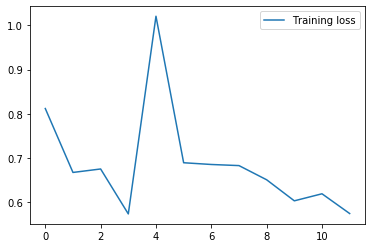

In [32]:
#####################
# Plot preds and performance
#####################
plt.plot(hist[0:12], label="Training loss")
plt.legend()
plt.show()

# plt.plot(y_pred.cpu().detach().numpy(), label="Preds")
# plt.plot(y_train.cpu().detach().numpy(), label="labels")
# plt.legend()
# plt.show() 



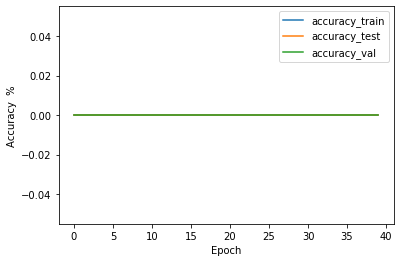

In [33]:
####################
# Plot preds and performance
####################
plt.plot(accuracy_train, label="accuracy_train")
plt.plot(accuracy_test, label="accuracy_test")
plt.plot(accuracy_val, label="accuracy_val")
plt.xlabel('Epoch')
plt.ylabel('Accuracy  %')
plt.legend()
plt.show()

Accuracy: 80.69767441860465% correct 347 total 430


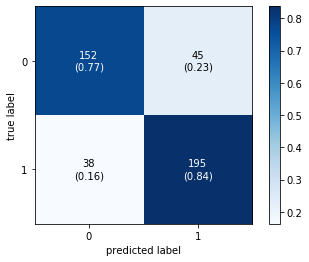

In [34]:
train_predicts, train_labels, accuracy = predict(model, train_loader)
cm = metrics.confusion_matrix(train_labels, train_predicts)

fig,ax = plot_confusion_matrix(cm, colorbar = True, show_normed = True)
plt.show()

Accuracy: 79.23076923076923% correct 103 total 130


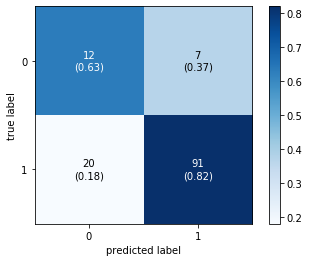

In [35]:
test_predicts, test_labels, accuracy = predict(model, test_loader)
cm = metrics.confusion_matrix(test_labels, test_predicts)

fig,ax = plot_confusion_matrix(cm, colorbar = True, show_normed = True)
plt.show()

Accuracy: 77.06422018348624% correct 84 total 109


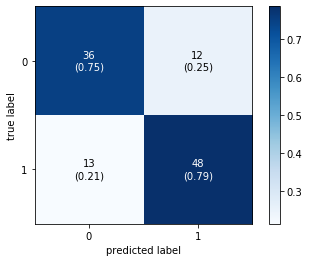

In [36]:
val_predicts, val_labels, accuracy = predict(model, val_loader)
cm = metrics.confusion_matrix(val_labels, val_predicts)

fig,ax = plot_confusion_matrix(cm, colorbar = True, show_normed = True)
plt.show()